In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import warnings
import json
from itertools import combinations

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [51]:
def categorize_numerical_col(col_name, bins, bins_name):
    new_col = f'{col_name}_categorized'
    df[new_col] = pd.cut(df[col_name], bins=bins, labels=bins_name)


def categorical_tests(test_type="vs-target", data=None, column=None, target=None, alpha=0.05):

    if test_type == "vs-target":
        con_table = pd.crosstab(data[column], data[target])
        stat, p_value, degree, _ = stats.chi2_contingency(con_table)
        result = {
            "categories vs target":test_type, "chi2_stat": stat, "p_value": p_value,
            "degrees_of_freedom": degree,
            "contingency_table": con_table.to_dict()
        }
        print('='*48)
        print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
        print('='*40)

    elif test_type == "vs-categories":
        categories = df[column].unique()
        category_pairs = list(combinations(categories, 2))
        result = []
        for group1, group2 in category_pairs:
            subset = df[df[column].isin([group1, group2])]
            contingency_table = pd.crosstab(subset[column], subset[target])
            chi2, p_value, degree, _ = stats.chi2_contingency(contingency_table)

            if p_value < alpha:
                print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
            else:
                print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        

def conversion_rate_barplot(df, group_col, target_col):
    tmp = df.groupby([group_col])[target_col].mean().reset_index()
    tmp.rename(columns={'Conversion': 'Conversion Rate'}, inplace=True)
    tmp['Conversion Rate'] *= 100

    fig = plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        data=tmp,
        x=group_col, 
        y='Conversion Rate',
        palette='viridis')
    ax.set_title(f'Conversion Rate by {group_col}')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=11, color='black',
                    xytext=(0, 10),
                    textcoords='offset points')

def draw_heatmap_groups(df, group1, group2):
    age_gender = df.groupby([group1, group2])['Conversion'].mean().reset_index()
    heatmap_data = age_gender.pivot_table(
        index=group1,
        columns=group2,
        values='Conversion'
    )
    heatmap_data.fillna(0, inplace=True)
    plt.figure(figsize=(18, 8))
    sns.heatmap(
        heatmap_data*100,
        cmap='YlGnBu',
        annot=True,
        linewidths=0.7,
        linecolor='lightgray'

    )
    plt.title(f'Heatmap of Conversion Rate by {group1}/{group2}', fontsize=18, weight='bold')
    plt.show()


In [2]:
df = pd.read_csv('marketing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2010 non-null   int64  
 1   Age                  2010 non-null   int64  
 2   Gender               2010 non-null   object 
 3   Income               1931 non-null   float64
 4   CampaignChannel      1856 non-null   object 
 5   CampaignType         2010 non-null   object 
 6   AdSpend              2010 non-null   object 
 7   ClickThroughRate     2010 non-null   float64
 8   ConversionRate       2010 non-null   float64
 9   WebsiteVisits        2010 non-null   int64  
 10  PagesPerVisit        2010 non-null   float64
 11  TimeOnSite           1931 non-null   float64
 12  SocialShares         2010 non-null   int64  
 13  EmailOpens           2010 non-null   int64  
 14  EmailClicks          2010 non-null   int64  
 15  PreviousPurchases    2010 non-null   i

In [3]:
df.nunique()

CustomerID             2010
Age                      52
Gender                    2
Income                 1923
CampaignChannel           6
CampaignType              4
AdSpend                2010
ClickThroughRate       2010
ConversionRate         2010
WebsiteVisits            50
PagesPerVisit          2010
TimeOnSite             1931
SocialShares            100
EmailOpens               20
EmailClicks              23
PreviousPurchases        10
LoyaltyPoints          1659
AdvertisingPlatform       1
AdvertisingTool           1
Conversion                2
dtype: int64

Deleting variables which doesn't give us much info

In [4]:
df = df.drop(columns=['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool'])

Time to clean up

In [13]:
df.isna().sum()

Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
Conversion             0
AdSpend_categorized    0
dtype: int64

In [6]:
df['CampaignChannel'] = df['CampaignChannel'].str.replace('email', 'Email')

In [7]:
df['CampaignChannel'] = df['CampaignChannel'].fillna('Other')

In [8]:
df['AdSpend'] = df['AdSpend'].astype(str).str.replace(r'[^\d\.]', '', regex=True).astype(float)


In [32]:
bins_AdSpend = [0, 2500, 5000, 7500, 10000]
bin_labels_AdSpend = ['Very Low Budget', 'Low Budget', 'Medium Budget', 'High Budget']
categorize_numerical_col('AdSpend', bins_AdSpend, bin_labels_AdSpend)


In [11]:
df['Income'].fillna(df['Income'].median(), inplace=True)

In [12]:
df['TimeOnSite'] = df.groupby(['WebsiteVisits'])['TimeOnSite'].transform(
    lambda x: x.fillna(x.mean())
)

In [14]:
df.head()


,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,AdSpend_categorized
0,36,Female,47648.0,Email,Consideration,893.755492,0.132078,0.198063,38,6.900081,11.923316,9,3,6,1,1139,1,Very Low Budget
1,32,Female,47491.0,Email,Consideration,7330.251375,0.120810,0.088416,27,4.589390,7.405528,33,0,2,4,3772,1,Medium Budget
2,52,Male,83830.0,Referral,Awareness,7720.360685,0.125472,0.082197,35,7.403157,0.660581,29,1,3,0,3611,1,High Budget
3,52,Male,116342.0,Social Media,Consideration,8337.453157,0.158739,0.089032,25,9.367090,12.218421,72,3,7,4,1173,1,High Budget
4,58,Female,90994.0,Email,Retention,5273.098832,0.226054,0.099792,13,7.968767,4.894079,41,16,7,0,1102,1,Medium Budget


<h1>KPI: Conversion Rate</h1>

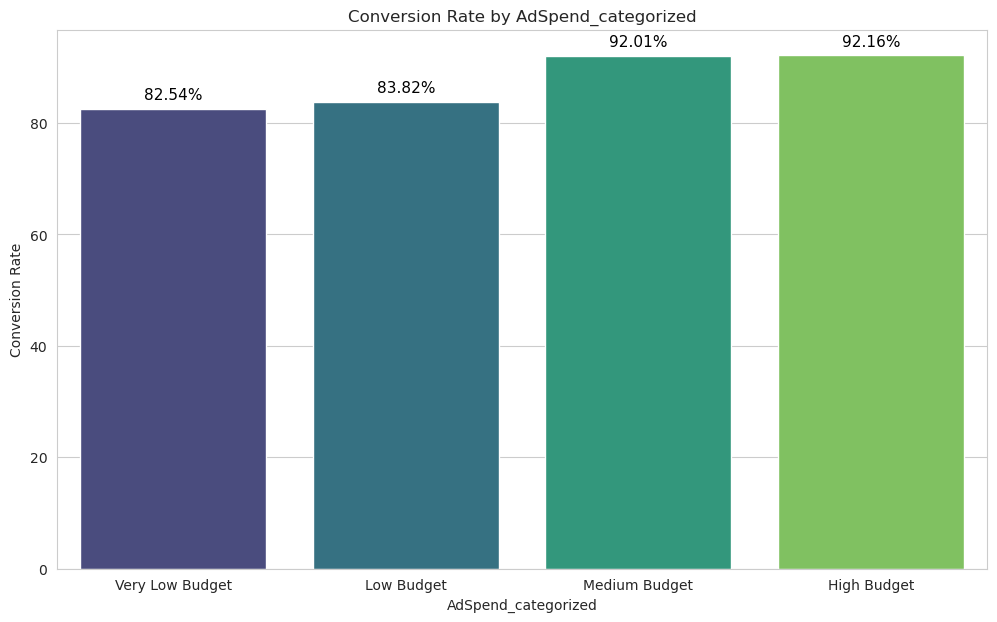

In [33]:

conversion_rate_barplot(df, 'AdSpend_categorized', 'Conversion')

In [34]:
categorical_tests(test_type="vs-categories", data=df, column='AdSpend_categorized', target='Conversion')

Significant difference between 'Very Low Budget' and 'Medium Budget': 
Chi2=20.0209, p-value=0.0000
Significant difference between 'Very Low Budget' and 'High Budget': 
Chi2=19.0497, p-value=0.0000
No significant difference between 'Very Low Budget' and 'Low Budget': 
Chi2=0.2077, p-value=0.6486
No significant difference between 'Medium Budget' and 'High Budget': 
Chi2=0.0000, p-value=1.0000
Significant difference between 'Medium Budget' and 'Low Budget': 
Chi2=16.0051, p-value=0.0001
Significant difference between 'High Budget' and 'Low Budget': 
Chi2=15.2941, p-value=0.0001


As we can see from the chi2 test between groups, we can regroup the AdSpend into two groups high and low.

In [39]:
bins_AdSpend = [0, 5000, np.inf]
bin_labels_AdSpend = ['<5K $', '>5K $']
categorize_numerical_col('AdSpend', bins_AdSpend, bin_labels_AdSpend)

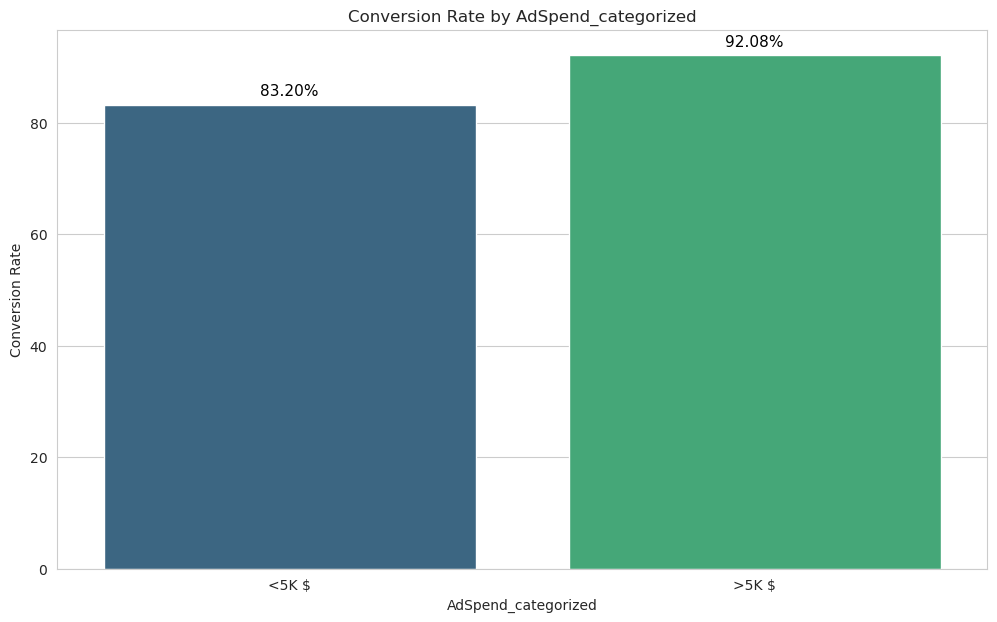

In [40]:
conversion_rate_barplot(df, 'AdSpend_categorized', 'Conversion')

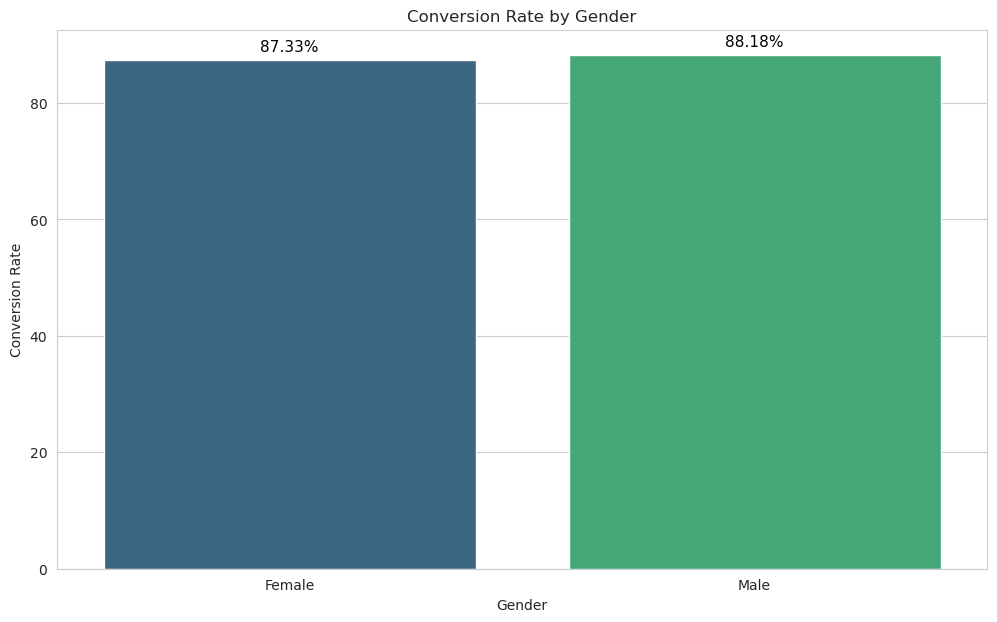

In [41]:
conversion_rate_barplot(df, 'Gender', 'Conversion')

As we can see the conversion rate between male and female users is fairly similar with maels being slightly higher.

In [43]:
bins = [18, 30, 45, 60, 70]
bin_labels = ['Young', 'Adult', 'Middle-Aged', 'Old']
categorize_numerical_col('Age', bins=bins, bins_name=bin_labels)

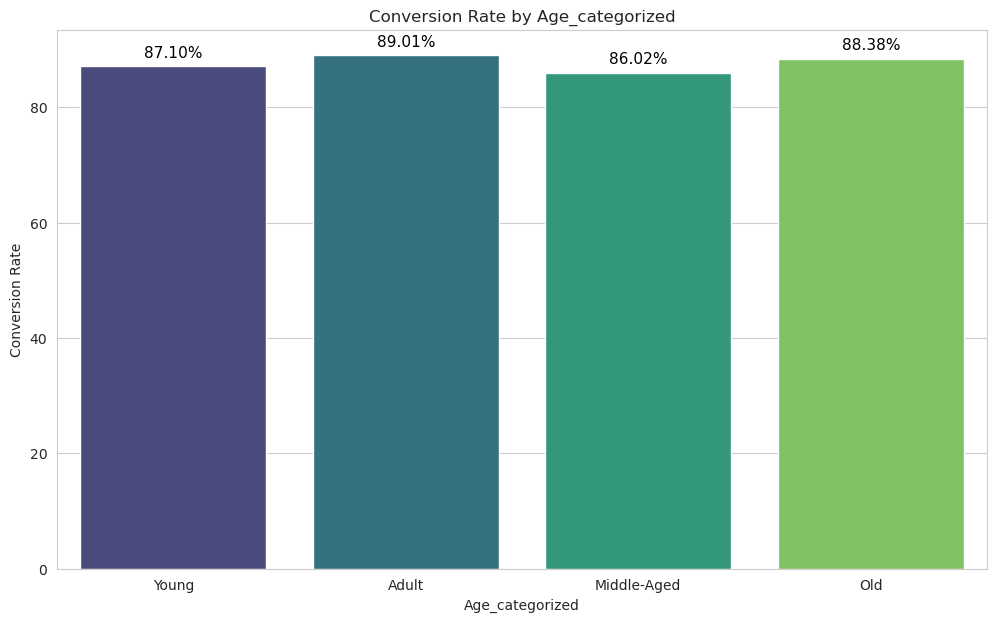

In [44]:
conversion_rate_barplot(df, 'Age_categorized', 'Conversion')

In [45]:
categorical_tests(test_type="vs-categories", data=df, column='Age_categorized', target='Conversion')

No significant difference between 'Adult' and 'Middle-Aged': 
Chi2=2.1518, p-value=0.1424
No significant difference between 'Adult' and 'Young': 
Chi2=0.7654, p-value=0.3817
No significant difference between 'Adult' and 'Old': 
Chi2=0.0347, p-value=0.8522
No significant difference between 'Adult' and 'nan': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Middle-Aged' and 'Young': 
Chi2=0.1726, p-value=0.6778
No significant difference between 'Middle-Aged' and 'Old': 
Chi2=0.8099, p-value=0.3681
No significant difference between 'Middle-Aged' and 'nan': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Young' and 'Old': 
Chi2=0.1844, p-value=0.6676
No significant difference between 'Young' and 'nan': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Old' and 'nan': 
Chi2=0.0000, p-value=1.0000


There is not much difference between age groups in terms of conversion rate.

!!!!What about age/gender group?

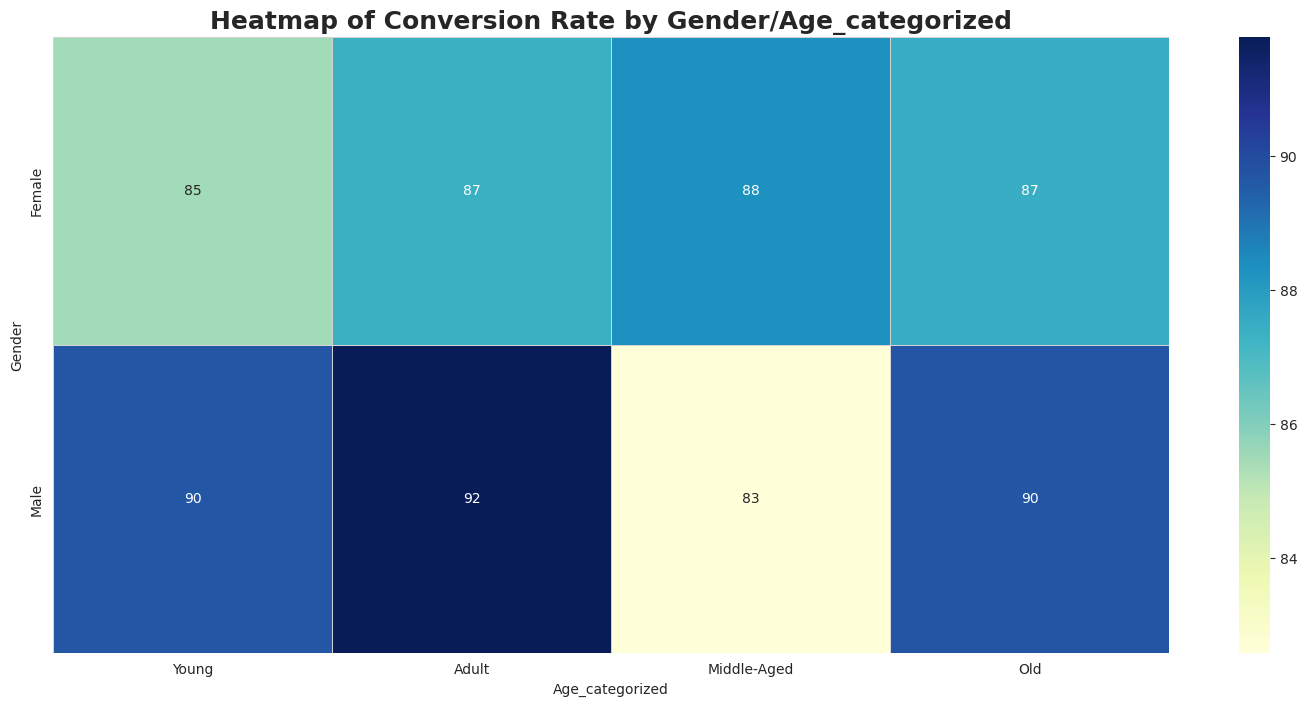

In [53]:
draw_heatmap_groups(df, 'Gender', 'Age_categorized')

As we can see here Adult Males has the highest conversion rate among male and in general,
while Middle-Aged Females has the highest conversion rate among females. another thing is that there is not much sudden change in female groups, as for male, there is more sudden group changes specially between adult and middle-aged

This map indicates that Middle-Aged males and Young females are two groups that the company should be working harder on.

----------

Let's see if CampaignChannel has effects in different age/gender groups.

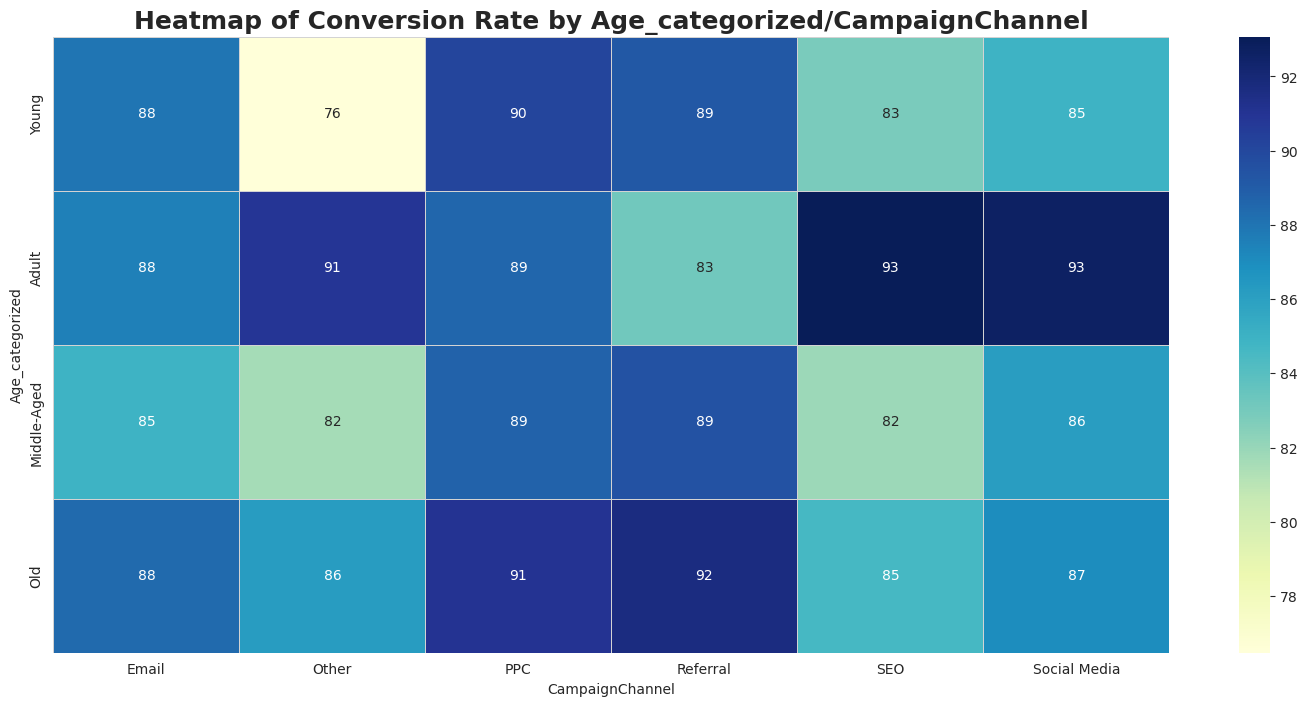

In [57]:
draw_heatmap_groups(df, 'Age_categorized', 'CampaignChannel')

here we can see that Social Media, SEO and Other groups have been very popular between adults. If you recall we fill the nan value of campaign channel with other. this map might be an indication that other group could be the combination of social media and seo group because it has very similar behavior in adult, middle-aged and old groups.

other than that, we can see PPC and Referral champaign are dominating the old groups an also very popular in young groups too. Email Campaign has a fairly similar behavior in all the age groups with middle-aged being the lowest.

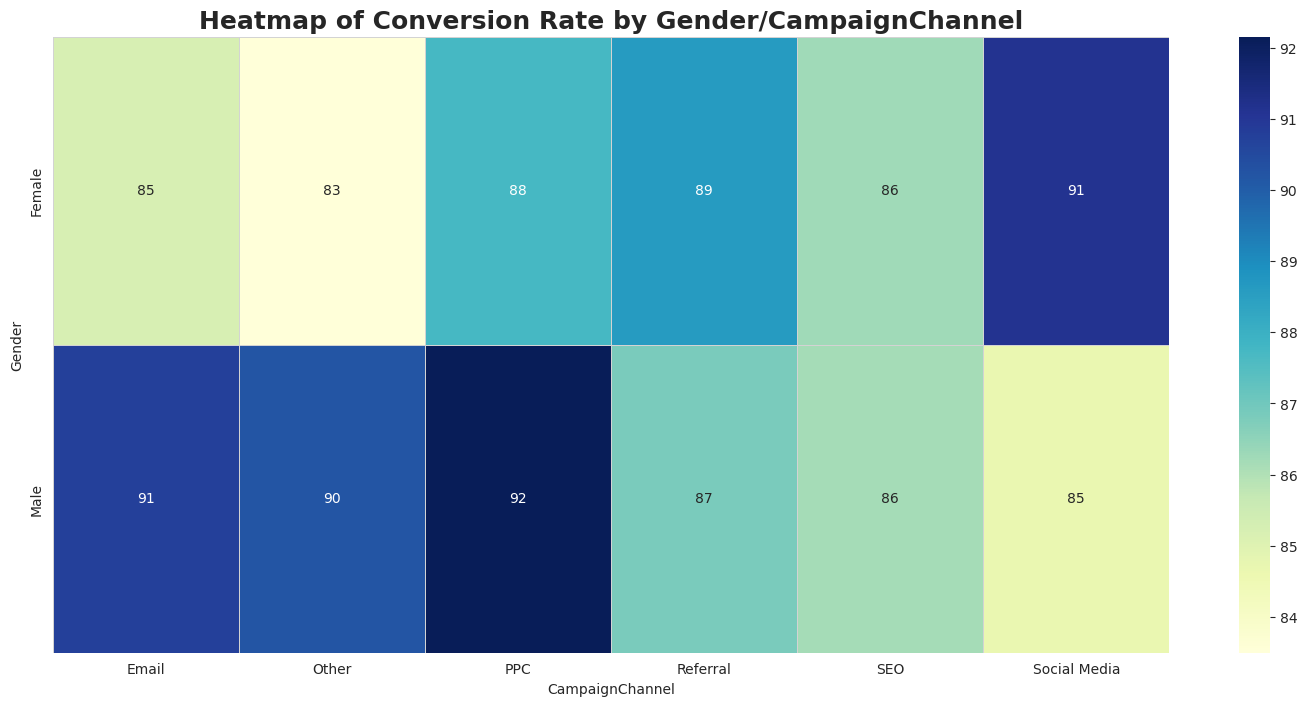

In [58]:
draw_heatmap_groups(df, 'Gender', 'CampaignChannel')

this plot shows that Email, Other, and PPc group are more popular among male costumers, while Social media is the dominant campaing between female costumers. Here we can see that other group is similar to PPC and email groups.

------------

First let's group our costumers based on how loyal they are.

In [62]:
bins = [-1, 1000, 2000, 3000, 4000, 5000]
bin_labels = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']
categorize_numerical_col('LoyaltyPoints', bins=bins, bins_name=bin_labels)

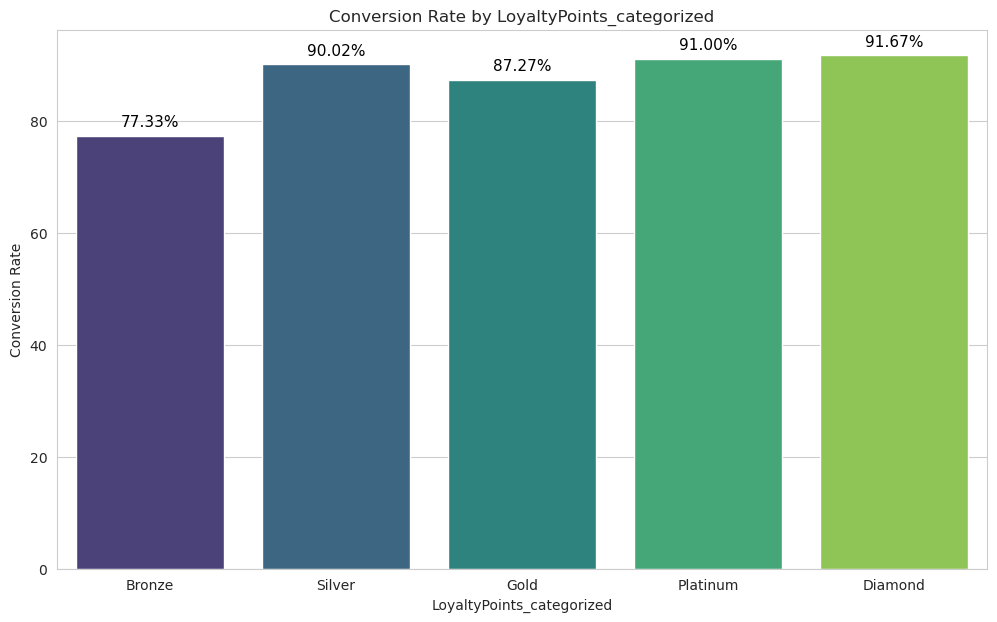

In [63]:
conversion_rate_barplot(df, 'LoyaltyPoints_categorized', 'Conversion')

As we can see the plots are generaly increasing (with silver group being an exception).